In [1]:
import glob
# from slab import *
#import PyInventor
#from PyInventor import *
%load_ext autoreload
%autoreload 2
#import pyEPR as epr
#from pyEPR import ansys as HFSS
import numpy as np

%matplotlib notebook

import pandas as pd
import pyEPR
from pyEPR import ansys as HFSS

import scipy
from scipy import constants as const

from pint import UnitRegistry
ureg = UnitRegistry()    
Q = ureg.Quantity
import os
import matplotlib.pyplot as plt

def flt2strfmt(val, fmt='%.3f', units='mm'):
    return (fmt % val) + units

import matplotlib
import datetime

# Add junction and chip

In [2]:
'''
HFSS eigenmode simulation Creation:

This sets up a standard eigenmode simulation without the qubit, just the bare cavity created above. It calculates
the mode frequencies, loss (with boundary impedances set) and the electric and magnetic surface participation 
ratios (S_e, S_m)

'''
# Toggle between eigenmode and driven modal
solution_type = 'driven_modal' # 'eigenmode'

# Define the cavity parameters [mm]
z_cav_1 = 100
y_cav_1 = 25
x_cav_1 = 10
z_cav_2 = 100
y_cav_2 = 25
x_cav_2 = 10
z_offset = 0
cav_thickness = 1

# Define the coupler parameters [mmm]
z_coupler = 20.
y_coupler = 0.5
x_coupler = 2.5

# Substrate dimensions
x_sub = x_coupler
y_sub = 0.450 # 450 um
z_sub = 5.

# Offsets of the junction pads
ycoupler_offset = 0.
zcoupler_offset = 0.

# Light and heavy modes (500, 100 um)
# l_junc = 500e-3
# l_junc = 100e-3
l_junc = 0.05
coupler_pads = (x_coupler - l_junc) / 2
y_pads = 0.1
w_junc = l_junc / 2 * 1e-3

# Project and HFSS design names for the bare waveguide model
dd = datetime.datetime.today().strftime('%y%m%d')
ref_name = 'planar_pads_l_coupled_three_geom2_cavities_bbq_y11'
project_name=f'{ref_name}_{dd}'
design_name=f'{ref_name}_hfss_design_{dd}'
overwrite=True

#use file location path:
HFSS_path=os.getcwd()

full_path=HFSS_path+'\\HFSS\\'+project_name+'.aedt'

HFSS_app=HFSS.HfssApp()
HFSS_desktop=HFSS_app.get_app_desktop()

project=HFSS_desktop.open_project(full_path)

if project==None:
    project=HFSS_desktop.new_project()
    project.save(full_path)
    
project.save(full_path)
project.make_active()
    
if design_name in project.get_design_names():
    if overwrite==True:
        project.delete_design(design_name)
        project.save()
        
        # Setup a driven modal design type
        if solution_type == 'driven_modal':
            EM_design=project.new_dm_design(design_name)
        elif solution_type == 'eigenmode':
            EM_design=project.new_dm_design(design_name)
        else:
            raise ValueError(f'Solution type ({solution_type}) not recognized.')
    else:
        EM_design=project.get_design(design_name)
        
else:
    if solution_type == 'driven_modal':
        EM_design=project.new_dm_design(design_name)
    elif solution_type == 'eigenmode':
        EM_design=project.new_dm_design(design_name)
    else:
        raise ValueError(f'Solution type ({solution_type}) not recognized.')
        
EM_design.make_active()
model=HFSS.HfssModeler(EM_design)

# Geometry parameters
zcav1 = EM_design.set_variable('z_cav_1', flt2strfmt(z_cav_1))
ycav1 = EM_design.set_variable('y_cav_1', flt2strfmt(y_cav_1))
xcav1 = EM_design.set_variable('x_cav_1', flt2strfmt(x_cav_1))
zcav2 = EM_design.set_variable('z_cav_2', flt2strfmt(z_cav_2))
ycav2 = EM_design.set_variable('y_cav_2', flt2strfmt(y_cav_2))
xcav2 = EM_design.set_variable('x_cav_2', flt2strfmt(x_cav_2))
zcpl  = EM_design.set_variable('z_coupler', flt2strfmt(z_coupler))
ycpl  = EM_design.set_variable('y_coupler', flt2strfmt(y_coupler))
xcpl  = EM_design.set_variable('x_coupler', flt2strfmt(x_coupler))
ycpl_offset = EM_design.set_variable('ycoupler_offset',
                                    flt2strfmt(ycoupler_offset))
zcpl_offset = EM_design.set_variable('zcoupler_offset',
                                    flt2strfmt(zcoupler_offset))
z_offset  = EM_design.set_variable('z_offset', flt2strfmt(z_offset))
x_cpl_offset = EM_design.set_variable('x_cpl_offset', flt2strfmt(2e3*x_cav_1))
tcav = EM_design.set_variable('cav_thickness', flt2strfmt(cav_thickness))
cpl_pads = EM_design.set_variable('coupler_pads', flt2strfmt(coupler_pads))
ypads = EM_design.set_variable('y_pads', flt2strfmt(y_pads))
ljunc = EM_design.set_variable('l_junc', flt2strfmt(l_junc))

xsub = EM_design.set_variable('x_sub', flt2strfmt(x_sub))
ysub = EM_design.set_variable('y_sub', flt2strfmt(y_sub))
zsub = EM_design.set_variable('z_sub', flt2strfmt(z_sub))

print(f'z_offset: {z_offset}')
print(f'x_cpl_offset: {x_cpl_offset}')

# Origin
pos=[0, 0, 0]

# Draw the cavities
## Define the cavity and coupler dimensions and positions
cav1_dims = [xcav1, ycav1, zcav1]
cav2_dims = [xcav1, ycav1, zcav2]

cav1_pos = [0, -ycpl/2-ycav1/2, 0]
cav2_pos = [0, ycpl/2+ycav2/2, 0]

cpl_dims = [xcpl, ycpl, zcpl/2]
cplout_dims = [xcpl+tcav, ycpl+tcav, zcpl/2+tcav]
cpl_pos = [0, 0, 0]


# cav1 = model.draw_box_center(cav1_pos, cav1_dims, name='cavity_1')
pad1_pos = [-cpl_pads/2-ljunc/2, ysub/2+ycpl_offset, zcpl_offset]
pad2_pos = [cpl_pads/2+ljunc/2, ysub/2+ycpl_offset, zcpl_offset]

pad_dims = [cpl_pads,  ypads, xcpl/10]
cpl  = model.draw_box_center(cpl_pos, cpl_dims, name='coupler')
cav1  = model.draw_box_center(cav1_pos, cav1_dims, name='cav1')
cav2  = model.draw_box_center(cav2_pos, cav2_dims, name='cav2')

model.unite(names=['coupler', 'cav1', 'cav2'],
            keep_originals=False)

# PEC cavity subtraction and realization
# cplout  = model.draw_box_center(cpl_pos, cplout_dims, name='coupler_outer')
# model.subtract(cplout, [cpl], keep_originals=True)
# model.assign_material(cplout, material='pec')

# cav2 = model.draw_box_center(cav2_pos, cav2_dims, name='cavity_2')

# Seed mesh for coupler box before uniting with cavities
# model.mesh_length(name_mesh='cpl', objects=[cpl], 
#                  max_length='%.3fum'%200)

#cavity = model.unite(names=['cavity_1', 'cavity_2','coupler'], 
#                     keep_originals=False)

# model.subtract(cpl, [pad1, pad2], keep_originals=False)

# Planar pads
pad1=model.draw_rect_center(pos=pad1_pos, x_size=pad_dims[0],
                          y_size=0,
                          z_size = pad_dims[2],
                          name='pad1')
pad2=model.draw_rect_center(pos=pad2_pos, x_size=pad_dims[0],
                          y_size=0,
                          z_size = pad_dims[2],
                          name='pad2')

# Substrate
sub_pos = [0, 0, 0]
sub_dims = [xsub, ysub, zsub]
substrate = model.draw_box_center(sub_pos, sub_dims, name='substrate')
model.assign_perfect_E([pad1, pad2], name='junction_pads')

project_name: planar_pads_l_coupled_three_geom2_cavities_bbq_y11_220717
path: Z:\tcav\ipynbs\HFSS\planar_pads_l_coupled_three_geom2_cavities_bbq_y11_220717.aedt


C:\Anaconda3\envs\py39\lib\site-packages\pyepr-0.8-py3.9.egg\pyEPR\ansys.py:486: UserWarning: No project in path of name: planar_pads_l_coupled_three_geom2_cavities_bbq_y11_220717.aedt
C:\Anaconda3\envs\py39\lib\site-packages\pyepr-0.8-py3.9.egg\pyEPR\ansys.py:487: UserWarning: Creating new project ...


z_offset: z_offset
x_cpl_offset: x_cpl_offset


## Assign the junction to be a lumped port

In [3]:
if solution_type == 'driven_modal':
    junc_loc = [0, ysub/2+ycpl_offset, zcpl_offset]
    jj=model.draw_rect_center(pos=junc_loc, x_size=xcpl-2*cpl_pads,
                              y_size=0,
                              z_size = w_junc,
                              name='jj')

    # model.assign_perfect_E([pad_1, pad_2], name='TPads')
    Lj_val=10.  #<---this sets the nominal Lj_val, should be same as start
    L_jj=EM_design.set_variable('Lj_1', '%.3fnH'%Lj_val)
    jj_line=model.draw_polyline(jj.make_center_line(axis='X'), 
                                closed=False, name='jj_line')
    jj.make_lumped_port('X', z0=1e6)
    DM_setup = EM_design.create_dm_setup()
    f1 = 5.; f2 = 13.; count = 20001
    DM_setup.insert_sweep(f1, f2,
                          count=count,
                          save_fields=True,
                          type='Interpolating')

### Assign loss to the substrate manually, then solve

In [4]:
DM_setup.solve()

0

## Combine data from several fine sweeps, fill with zeros in between

In [111]:
def combine_multiple_data(files : list, Nzeros : int=10):
    """
    Combines data from multiple sweeps, fills with zeros outside of run
    """
    # Iterate over all files
    zero_pad = np.ones(Nzeros)
    fdata = np.array([])
    yredata = np.array([])
    yimdata = np.array([])
    data0 = np.genfromtxt(files[0], delimiter=',', skip_header=1).T
    
    if len(files) > 1:
        for fidx, file in enumerate(files[1:]):

            # Get the current data file
            data1 = np.genfromtxt(file, delimiter=',', skip_header=1).T
            
            # Store the previous data
            fdata = np.hstack((fdata, data0[0]))
            yredata = np.hstack((yredata, data0[1]))
            yimdata = np.hstack((yimdata, data0[2]))
            
            # Determine the frequency array and zeros to append
            fapp = np.linspace(data0[0,-1], data1[0,0], Nzeros)
            print(f'fapp: [{fapp[0]/1e9}, {fapp[-1]/1e9}] GHz')
            fdata = np.hstack((fdata, fapp))
            yredata = np.hstack((yredata, zero_pad * yredata[-1]))
            yimdata = np.hstack((yimdata, zero_pad * yimdata[-1]))
            data0 = np.copy(data1)
            
        # Store the last data set
        fdata = np.hstack((fdata, data0[0]))
        yredata = np.hstack((yredata, data0[1]))
        yimdata = np.hstack((yimdata, data0[2]))
        
        # Convert to numpy arrays and make y complex
        fdata = np.asarray(fdata).flatten()
        ydata = yredata.flatten() + 1j * yimdata.flatten()
        
        return fdata, ydata

## Postprocessing, blackbox quantization

In [112]:
def get_wp_Cp_Lp(f, y, LJ0=10e-9, CJ0=2e-15, fscale=1e9, use_Zq=False):
    """
    Converts frequency-dependent imaginary parts
    of the admittance data to poles,
    capacitances, and inductances
    """
    # Add the junction inductance and capacitance to the
    # total admittance
    # Compute the zero crossings
    fcpy = np.copy(f * fscale)
    ycpy = np.copy(np.complex128(y))
    if LJ0:
        ycpy += (1. / (1j * fcpy * 2 * np.pi * LJ0)) \
          + 1j * fcpy * 2 * np.pi * CJ0
    
    yim = ycpy.imag
    zero_xing_idxs = np.where(np.diff(np.sign(yim)))[0]
    wp = 2 * np.pi * fcpy[zero_xing_idxs]
    yp = yim[zero_xing_idxs]

    # Compute the capacitances from the derivatives
    ypp = np.gradient(ycpy, 2*np.pi*(fcpy[1]-fcpy[0]))
    Cp = 0.5 * np.abs(ypp.imag[zero_xing_idxs])
    Lp = 1. / (wp**2 * Cp)
    Zp = np.sqrt(Lp / Cp)
    Rp = 1. / np.abs(np.real(ycpy[zero_xing_idxs]))
    Qp = wp * Rp * Cp
    
    # Physical constants
    h    = 6.62607015e-34 
    hbar = h / (2 * np.pi)
    e    = 1.602176634e-19
    Phi0 = h / (2 * e)
    
    # Compute Ej, Ec
    if LJ0 and CJ0:
        # Compute the Josephson inductive and charging energies
        Ej = (Phi0 / (2 * np.pi))**2 / LJ0
        Ec = e**2 / (2 * CJ0)

        # Compute inductive energies, EL
        EL = 0.5 * Phi0**2 / Lp

        # Compute the phase zero point fluctuations
        GQ = 2 * e**2 / h
        phip2 = 2 * np.pi * GQ * Zp

        # Compute the participations
        # p = phi2 * 2 * Ej / (hbar * wp)
        pl = Lp / LJ0
        pc = Cp / CJ0

        # Compute the gs / Ds
        Zq = np.sqrt(LJ0 / CJ0)
        gD = np.sqrt(Zp / Zq)

        # Compute the chis, anharmonicities
        # In units of Hz
        chipp  = -Ec * gD**2 / h
        chippp = np.asarray([-2 * np.sqrt(chipp[p] * chipp[q]) 
                             for p in range(len(chipp))
                             for q in range(len(chipp))])
        chippp = chippp.reshape([len(chipp), len(chipp)])

        return wp, Lp, Cp, Qp, fcpy, ycpy, yp, pl, pc, gD, chippp
    
    else:
        return wp, Lp, Cp, Qp, fcpy, ycpy, yp, None, None, None, None

In [113]:
def set_axes_fonts(ax, fsize):
    """
    Set axes font sizes because it should be abstracted away
    """
    for tick in ax.get_xticklabels():
        tick.set_fontsize(fsize)
    for tick in ax.get_yticklabels():
        tick.set_fontsize(fsize)

def set_xaxis_rot(ax, angle=45):
    """
    Rotate the x-axis labels
    """
        
    for tick in ax.get_xticklabels():
        tick.set_rotation(angle)

def set_leg_outside(ax, fsize):
    """
    Sets the legend location outside
    """
    
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    
    # Put a legend to the right of the current axis
    hdls, legs = ax.get_legend_handles_labels()
    leg = ax.legend(hdls, legs, loc='center left', bbox_to_anchor=(1, 0.5), \
                    fontsize=fsize, framealpha=0.)

    return leg

## Load and plot the Eigenmode data

#### Combine data files with the function above

In [118]:
freqs_in = [6, 7, 9, 11]
freqs_in = ['5_6_141', '6_141_6_151', '6_151_7_465',
            '7_465_7_475', '7_475_9_58',
            '9_58_9_59', '9_59_11_96',
           '11_96_11_97', '11_97_12_084',
           '12_084_12_094', '12_094_12_104']
files = [f'../data/y11_sapphire_three_cavities_planar_plates_long_coupler_{f}_GHz_220717.csv'
         for f in freqs_in]
fdata, ydata = combine_multiple_data(files)

fapp: [6.141e-09, 6.141e-09] GHz
fapp: [6.151e-09, 6.151e-09] GHz
fapp: [7.465e-09, 7.465e-09] GHz
fapp: [7.474999999999999e-09, 7.474999999999999e-09] GHz
fapp: [9.58e-09, 9.58e-09] GHz
fapp: [9.59e-09, 9.59e-09] GHz
fapp: [1.1960000000000001e-08, 1.1960000000000001e-08] GHz
fapp: [1.197e-08, 1.197e-08] GHz
fapp: [1.2084e-08, 1.2084e-08] GHz
fapp: [1.2093999999999999e-08, 1.2093999999999999e-08] GHz


In [119]:
fdata

array([ 5.      ,  5.005705,  5.01141 , ..., 12.1039  , 12.10395 ,
       12.104   ])

In [120]:
ydata

array([9.96197345e-11-0.00339021j, 9.97492722e-11-0.00336928j,
       9.98789144e-11-0.00334835j, ..., 2.03462330e-10+0.00223908j,
       2.03521137e-10+0.00224642j, 2.03574543e-10+0.00225359j])

<IPython.core.display.Javascript object>


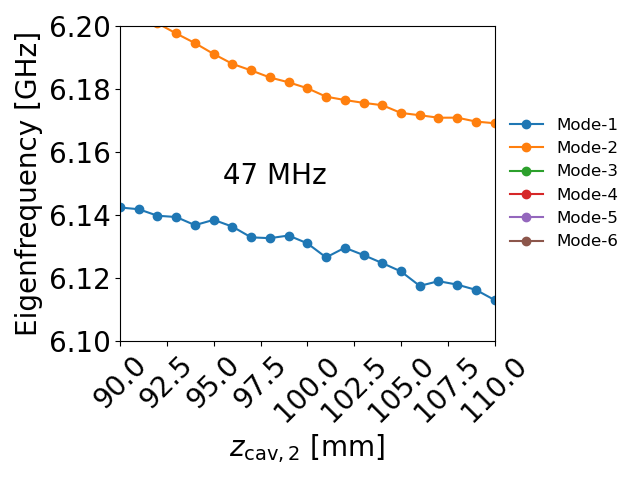

dw: 46.87905815912056 MHz


In [121]:
# Load the data from the z-coupler sweep
# Load the data from the y-coupler sweep
fsize = 20; lsize = 12
fname_eigenmode = '../data/geometric_degenerate_coupler_splitting_vs_z_coupler_220709.csv'
# fname_eigenmode = '../data/geometric_nondegenerate_coupler_splitting_vs_y_coupler.csv'
# fname_eigenmode = '../data/geometric_degenerate_coupler_splitting_vs_y_coupler.csv'
fname_eigenmode = '../data/modes_vs_zcav2_220709.csv'
data = np.genfromtxt(fname_eigenmode, delimiter=',', skip_header=1).T
zdata = np.unique(data[1])
wdata = data[2:]
Nmodes = 6
fig, ax = plt.subplots(1, 1, tight_layout=True)
for widx, w in enumerate(wdata[0:Nmodes]): 
    ax.plot(zdata, w/1e9, 'o-', label=f'Mode-{widx+1}')
# ax.set_xlabel(r'$z_{\mathrm{coupler}}$ [mm]', fontsize=fsize)
ax.set_xlabel(r'$z_{\mathrm{cav,2}}$ [mm]', fontsize=fsize)
ax.set_ylabel(r'Eigenfrequency [GHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
ax.set_xlim([90, 110])
ax.set_ylim([6.1, 6.2])
dw = np.min(wdata[1, :] - wdata[0, :])
print(f'dw: {dw/1e6} MHz')
ax.annotate(f'{dw/1e6 : .0f} MHz', (95., 6.15), fontsize=fsize)
leg = set_leg_outside(ax, lsize)
fig.savefig('../figs/modes_vs_zcoupler_degenerate_220709.pdf',
           format='pdf')

In [20]:
## Load the data manually exported from HFSS Y-parameter plots

# Load the data from file, combine as one wide frequency sweep
yredata = []
yimdata = []
fdata = []
# Set the directories and name the files in a sane fashion
# dstr = '220205'
# dstr = '211217'
# dstr ='220511'
dstr ='220513'
dstr = '220531'
dstr = '220707'
dstr = '220717'
data_prefix = f'../data/y11_monolithic_pads'
data_prefix = '../data/y11_ycpl_sweep'
data_prefix = '../data/y11_sapphire_three_cavities_planar_plates'
data_prefix = '../data/y11_sapphire_three_cavities_planar_plates_long_coupler'
# data_prefix = '../data/y11_zcpl_sweep'
is_zcpl_offset = False
# is_zcpl_offset = True
is_ycpl_offset = False
# is_ycpl_offset = False
fswp1 = f'{data_prefix}_5_25GHz_50um_offset_{dstr}.csv'
fswp1 = f'{data_prefix}_5_20GHz_{dstr}.csv'
fswp1 = f'{data_prefix}_5_13GHz_{dstr}.csv'
# fswp1 = f'{data_prefix}_5_25GHz_50um_{dstr}.csv'

# Iterate over all of the files

# JJ position sweep unraveling
data = np.genfromtxt(fswp1, delimiter=',', skip_header=1).T

if is_zcpl_offset:
    xdata = np.unique(data[0])
    fdata = np.unique(data[1])
    yredata = data[2].reshape(xdata.size, fdata.size)
    yimdata = data[3].reshape(xdata.size, fdata.size)
    xscale = z_coupler / 4
elif is_ycpl_offset:
    xdata = np.unique(data[0])
    fdata = np.unique(data[1])
    yredata = data[2].reshape(xdata.size, fdata.size)
    yimdata = data[3].reshape(xdata.size, fdata.size)
    xscale = y_coupler / 2
else:
    data = np.genfromtxt(fswp1, delimiter=',', skip_header=1).T
    fdata = data[0]
    yredata = data[1]
    yimdata = data[2]

# Combine and flatten the data
# fdata = np.asarray(fdata).flatten()
# yredata = np.asarray(yredata).flatten()
#yimdata = np.asarray(yimdata).flatten()
ydata = yredata + 1j * yimdata

# Remove last point
ydata.shape

(20001,)

In [122]:
ydata.shape

(2311,)

In [123]:
fdata.shape

(2311,)

<IPython.core.display.Javascript object>


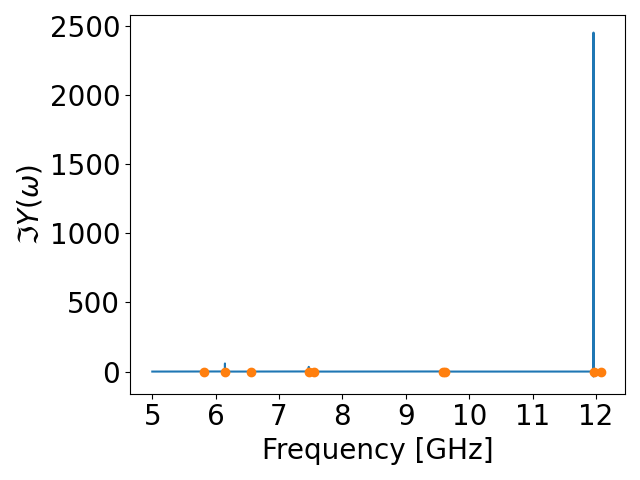

In [124]:
# Plot the results, save the figure(s)
fsize = 20
fscale = 1e9
wp, Lp, Cp, Qp, fcpy, ycpy, yp, pl, pc, gD, chippp = \
get_wp_Cp_Lp(fdata, ydata, LJ0=None, CJ0=None, fscale=1e9, use_Zq=False)

fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.plot(fdata, ydata.imag)
ax.plot(wp/(2*np.pi*fscale), yp.imag, 'o', label='Zero Crossings')
ax.set_ylabel(r'$\Im Y(\omega)$', fontsize=fsize)
ax.set_xlabel(r'Frequency [GHz]', fontsize=fsize)
set_axes_fonts(ax, fsize)
#ax.set_xlim([6.08, 6.081])
# fig.savefig(f'../figs/zeros_term_bbq_inductive_50um_{dstr}.pdf', format='pdf')

## Iterate over all coupler offset values, fix LJ=10 nH

In [145]:
NLJ = 35
wps = []
pcs = []
pls = []
gDs = []
Cps = []
Lps = []
Qps = []
chis = []
Nmodes = 6

# Whether or not to use the largest impedance mode
# as the junction mode in the calculations
use_Zq = False
print_results = True

LJs = np.logspace(np.log10(0.1e-9), np.log10(1000e-9), NLJ)
# LJs = np.logspace(np.log10(1e-9), np.log10(100e-9), NLJ)
# LJs = np.logspace(np.log10(0.00001e-9), np.log10(0.0001e-9), NLJ)
# LJs = np.logspace(np.log10(0.1), np.log10(100), NLJ)
LJ0 = 10e-9
#for idx, x in enumerate(xdata):
for LJ in LJs:
    wpp, Lp, Cp, Qp, _, _, _, pl, pc, gD, chip \
    = get_wp_Cp_Lp(fdata, ydata, LJ0=LJ, fscale=fscale, use_Zq=use_Zq)
    if print_results:
        print(f'wpp: {wpp}')
        print(f'Lp: {Lp}')
        print(f'Cp: {Cp}')
        print(f'pl: {pl}')
        print(f'pc: {pc}')
        print(f'chip: {chip}')
    # wps.append(np.sort(wpp[0:Nmodes])[::-1])
    wps.append(wpp[0:Nmodes])
    pls.append(pl[0:Nmodes])
    pcs.append(pc[0:Nmodes])
    gDs.append(gD[0:Nmodes])
    Lps.append(Lp[0:Nmodes])
    Cps.append(Cp[0:Nmodes])
    Qps.append(Qp[0:Nmodes])
    chis.append(chip[0:Nmodes, 0:Nmodes])
    # wps.append(wpp)
    # print(f'LJ: {LJ}, wpp: {wpp}')
wps = np.asarray(wps).T
pls  = np.asarray(pls).T
pcs  = np.asarray(pls).T
gDs = np.asarray(gDs).T
Lps = np.asarray(Lps).T
Cps = np.asarray(Cps).T
Qps = np.asarray(Qps).T
chis = np.asarray(chis).T

wpp: [3.86101737e+10 3.86199126e+10 4.69206288e+10 4.69291111e+10
 6.01998267e+10 6.02092515e+10 7.49979848e+10 7.51604051e+10]
Lp: [5.84241832e-12 5.91980652e-15 4.21860340e-12 5.56117171e-15
 3.83897443e-12 2.83200993e-15 3.19768087e-13 3.59004650e-16]
Cp: [1.14816377e-10 1.13258267e-07 1.07672217e-10 8.16486558e-08
 7.18777209e-11 9.74044440e-08 5.55988353e-10 4.93084898e-07]
pl: [5.84241832e-02 5.91980652e-05 4.21860340e-02 5.56117171e-05
 3.83897443e-02 2.83200993e-05 3.19768087e-03 3.59004650e-06]
pc: [5.74081886e+04 5.66291336e+07 5.38361085e+04 4.08243279e+07
 3.59388604e+04 4.87022220e+07 2.77994176e+05 2.46542449e+08]
chip: [[-1.95408821e+07 -6.22094501e+05 -1.83047256e+07 -6.64662657e+05
  -1.97789027e+07 -5.37249429e+05 -6.37146525e+06 -2.13718224e+05]
 [-6.22094501e+05 -1.98047133e+04 -5.82740794e+05 -2.11598935e+04
  -6.29672013e+05 -1.71036248e+04 -2.02839026e+05 -6.80383469e+03]
 [-1.83047256e+07 -5.82740794e+05 -1.71467684e+07 -6.22616087e+05
  -1.85276890e+07 -5.03263

In [146]:
wp0,_ , _, _, _, _, _, _, _, _, _ = get_wp_Cp_Lp(fdata, ydata, fscale=fscale, LJ0=None)

In [147]:
wp0/(2*np.pi*fscale)

array([ 5.81011,  6.14655,  6.55177,  7.469  ,  7.5592 ,  9.5826 ,
        9.6137 , 11.96215, 12.0841 ])

In [148]:
wp0.shape

(9,)

In [149]:
wps.shape

(6, 35)

## Plot the modes of coupled structure

<IPython.core.display.Javascript object>


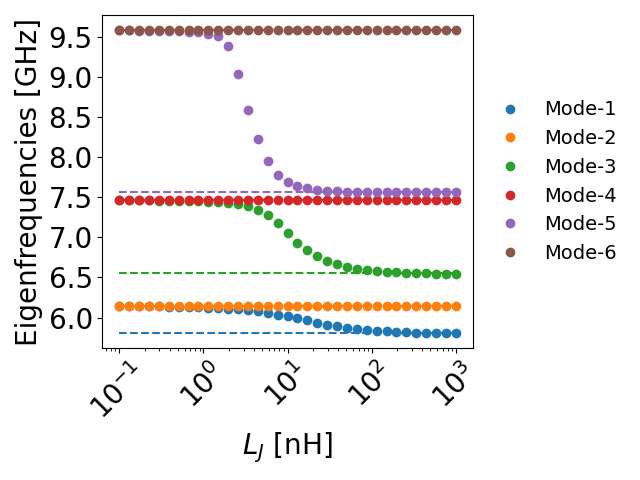

In [150]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, wppp in enumerate(wps):
    ax.plot(LJs/1e-9, wppp/(2*np.pi*fscale),
            'o', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
    ax.plot(LJs/1e-9, [wp0[idx]/(2*np.pi*fscale)] * len(LJs),
            '--', color=cycle[idx%clen])
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Eigenfrequencies [GHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('log')
fig.savefig(f'../figs/modes_term_bbq_inductive_planar_sapphire_{dstr}.pdf', format='pdf')

In [140]:
dw

46879058.15912056

## Plot the splittings of the lowest modes vs LJ

<IPython.core.display.Javascript object>


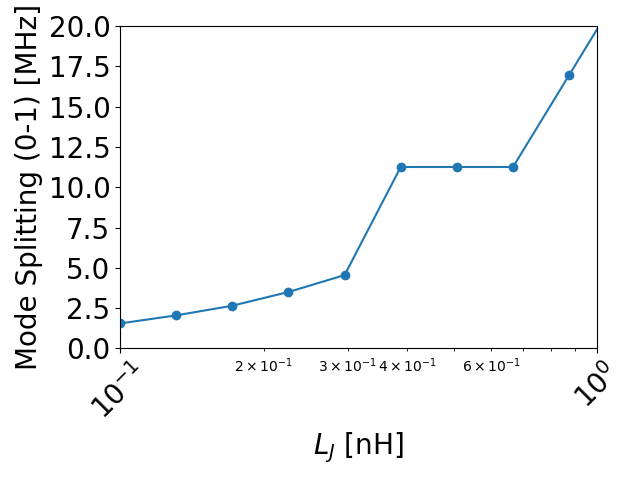

In [153]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
fscale2 = 1e6
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
ax.plot(LJs/1e-9, (wps[1]-wps[0])/(2*np.pi*fscale2),
           'o-',
            color=cycle[0%clen])
ax.plot(LJs/1e-9, np.ones(LJs.size) * dw/(fscale2), 'k--')
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'Mode Splitting (0-1) [MHz]', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
ax.set_ylim([0, 20])
ax.set_xlim([1e-1, 1])
ax.set_xscale('log')
fig.savefig(f'../figs/modes_splitting_term_bbq_inductive_planar_sapphire_{dstr}.pdf',
            format='pdf')

## Mode losses

<IPython.core.display.Javascript object>


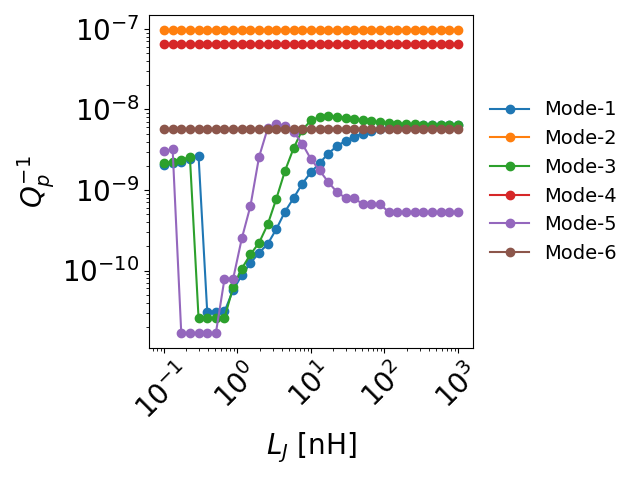

In [154]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
lsize = 14
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
clen = len(cycle)
for idx, Q in enumerate(Qps):
    ax.plot(LJs/1e-9, 1./Q,
            'o-', label=r'Mode-%d' % (idx + 1),
            color=cycle[idx%clen])
ax.set_xlabel(r'$L_J$ [nH]', fontsize=fsize)
ax.set_ylabel(r'$Q_p^{-1}$', fontsize=fsize)
set_xaxis_rot(ax, 45)
set_axes_fonts(ax, fsize)
set_leg_outside(ax, lsize)
ax.set_xscale('log')
ax.set_yscale('log')
fig.savefig(f'../figs/mode_losses_term_bbq_inductive_planar_sapphire_{dstr}.pdf', format='pdf')